In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

1.1 Implement gradient-based factorisation using PyTorch's AD

In [2]:
from typing import Tuple

def gd_factorise_ad(A: torch.Tensor, rank: int, num_epochs = 1000, lr = 0.01) -> Tuple[torch.tensor, torch.tensor]:

  m, n = A.shape
  U = torch.rand(m , rank, requires_grad=True)
  V = torch.rand(n , rank, requires_grad=True)

  for epoch in range(num_epochs):
    norm_loss = torch.nn.functional.mse_loss(input = A, target = U @ V.T, reduction= 'sum')
    norm_loss.backward()

    U.data = U.data - U.grad.data * lr
    V.data = V.data - V.grad.data * lr

    U.grad.data.zero_()
    V.grad.data.zero_()

  return U, V

In [3]:
A = torch.Tensor(
    [[0.3374, 0.6005, 0.1735],
     [3.3359, 0.0492, 1.8374],
     [2.9407, 0.5301, 2.2620]]
)

U, V = gd_factorise_ad(A, rank = 2)
print("U = ", U)
print()
print("V = ", V)
print()

norm_loss = torch.nn.functional.mse_loss(input = A, target = U @ V.T, reduction= 'sum')
print(norm_loss)

U =  tensor([[-0.3143,  0.5761],
        [ 1.4367,  0.9582],
        [ 0.8594,  1.4892]], requires_grad=True)

V =  tensor([[ 1.4699,  1.1915],
        [-0.4464,  0.6597],
        [ 0.7018,  1.0071]], requires_grad=True)

tensor(0.1219, grad_fn=<MseLossBackward0>)


1.2 Factorise and compute reconstruction error on real data


In [4]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'+'/iris/iris.data', header=None)
data = torch.tensor(df.iloc[:, [0,1,2,3]].values)
data = data - data.mean(dim=0)
data = data.type(torch.float32)


Using gd_factorise_ad

In [5]:
U, V = gd_factorise_ad(data, rank = 2 )
gd_loss = torch.nn.functional.mse_loss(input = data, target = U @ V.T, reduction= 'sum')

print(gd_loss)

tensor(15.2290, grad_fn=<MseLossBackward0>)


Using SVD

In [ ]:
U, S, V = torch.svd(data)
S[2] = S[3] = 0
data_svd = U @ torch.diag(S) @ V.T
svd_loss = torch.nn.functional.mse_loss(input = data, target = data_svd, reduction= 'sum')

print(svd_loss)

tensor(15.2288)


1.3 Compare against PCA

In [ ]:
import matplotlib.pyplot as plt

Plot using SVD

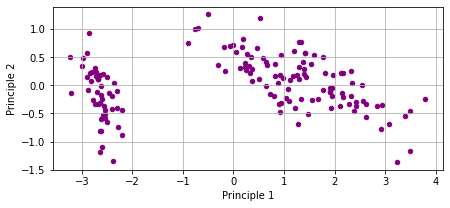

In [ ]:
U, S, V = torch.svd(data)
S[2] = S[3] = 0
data_svd = U @ torch.diag(S)
fig, ax = plt.subplots(figsize=(7,3))
ax.grid(True)
ax.set_xlabel("Principle 1")
ax.set_ylabel("Principle 2")
plt.scatter(data_svd[:, 0], data_svd[:, 1], s=20, c='purple')

Plot using data from U

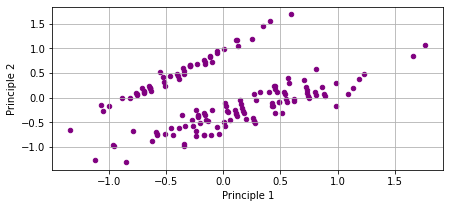

In [ ]:
U, V = gd_factorise_ad(data, rank = 2)
fig, ax = plt.subplots(figsize=(7,3))
ax.grid(True)
ax.set_xlabel("Principle 1")
ax.set_ylabel("Principle 2")
plt.scatter(U.data[:, 0], U.data[:, 1], s=20, c='purple')

2.1 Implement the MLP

In [ ]:
import numpy as np

def create_mlp(training_data: torch.Tensor, training_target_data: torch.Tensor,
               validation_data: torch.Tensor, validation_target_data: torch.Tensor, 
               num_epochs = 100, lr_rate = 0.01):
  W1 = torch.rand(4,12, requires_grad=True)
  W2 = torch.rand(12,3, requires_grad=True)

  b1 = torch.tensor(0.0, requires_grad=True)
  b2 = torch.tensor(0.0, requires_grad=True)

  # Train the data
  for epoch in range(num_epochs):

    logits = torch.relu(training_data @ W1 +b1) @ W2 + b2
    entropy = torch.nn.functional.cross_entropy(logits, training_target_data)
    entropy.backward()

    W1.data = W1.data + lr_rate * W1.grad.data
    W2.data = W2.data + lr_rate * W2.grad.data

    b1.data = b1.data + lr_rate * b1.grad.data
    b2.data = b2.data + lr_rate * b2.grad.data

    W1.grad.zero_()
    W2.grad.zero_()
    b1.grad.zero_()
    b2.grad.zero_()

  # Training Accuracy
  training_pred = torch.relu(training_data @ W1 + b1) @ W2 +b2
  final_training_prediction = torch.argmax(training_pred, dim = 1)
  training_accuracy = sum(final_training_prediction == training_target_data)/len(training_data)

  # Validation Accuracy
  validation_pred = torch.relu(validate_data @ W1 + b1) @ W2 +b2
  final_validation_prediction = torch.argmax(validation_pred, dim = 1)
  validation_accuracy = sum(final_validation_prediction == validate_target_data)/len(validate_data)

  return training_accuracy.item() * 100, validation_accuracy.item() * 100


2.2 Test the MLP

In [ ]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'+'/iris/iris.data', header=None)
df = df.sample(frac = 1) # shuffle

# add label indices column
mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = df[4].map(mapping)

# normalise data
alldata = torch.tensor(df.iloc[:, [0, 1, 2, 3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)

# create datasets
training_target_data = torch.tensor(df.iloc[:100, 5].values, dtype = torch.long)
validate_target_data = torch.tensor(df.iloc[100:, 5].values, dtype = torch.long)
training_data = alldata[:100]
validate_data = alldata[100:]


for i in range(10):
  training_accuracy, validation_accuracy = create_mlp(training_data, training_target_data, validate_data, validate_target_data)
  print(i+1,"training accuracy:", training_accuracy,"validation accuracy:", validation_accuracy)



1 training accuracy: 37.99999952316284 validation accuracy: 23.999999463558197
2 training accuracy: 31.00000023841858 validation accuracy: 37.99999952316284
3 training accuracy: 25.0 validation accuracy: 28.00000011920929
4 training accuracy: 31.00000023841858 validation accuracy: 37.99999952316284
5 training accuracy: 37.99999952316284 validation accuracy: 23.999999463558197
6 training accuracy: 37.99999952316284 validation accuracy: 23.999999463558197
7 training accuracy: 37.99999952316284 validation accuracy: 23.999999463558197
8 training accuracy: 31.999999284744263 validation accuracy: 37.99999952316284
9 training accuracy: 31.999999284744263 validation accuracy: 37.99999952316284
10 training accuracy: 37.99999952316284 validation accuracy: 23.999999463558197
